In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-gs/build/python')
sys.path.append("..")

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool
mi.set_variant('cuda_ad_rgb')

%load_ext autoreload
%autoreload 2

jit_find_library(): Unable to load "/usr/lib/llvm-15/lib/libLLVM.so": /home/jonathan/miniconda3/envs/volprim/lib/python3.11/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/llvm-15/lib/libLLVM.so)!


In [17]:
from scripts.restir.test_reservoir import test_reservoir

test_reservoir()

[1.88496 1.88496 0.     ]
Naive:		[1.79856 1.79856 0.     ] +- [0.35312 0.35312 0.     ]
Single:		[1.79856 1.79856 0.     ] +- [0.35312 0.35312 0.     ]
Multi:		[1.79856 1.79856 0.     ] +- [0.35312 0.35312 0.     ]
Single+T:	[1.87126 1.87126 0.     ] +- [0.06243 0.06243 0.     ]
Multi+T:	[1.8821 1.8821 0.    ] +- [0.06029 0.06029 0.     ]


In [5]:
import volprim
from volprim.integrators.common import *

In [6]:
from scripts.radiosity.radiance_cache import RadianceCache
from scripts.radiosity.surface_sampler import SceneSurfaceSampler
from scripts.radiosity.vertex_bsdf import Diffuse, Principled

# scene_path = "/home/jonathan/Documents/volprim-balance/scenes/mitsuba/cabinet/scene_remesh.xml"
# scene = mi.load_file(scene_path)
# # gs_path = "/home/jonathan/Documents/gaussian-splatting-exr/output/cabinet_logL1_static-SSIM_hdrPcd_envImpt/point_cloud/iteration_30000/point_cloud.ply"
# gs_path = "/home/jonathan/Documents/gaussian-splatting-exr/output/cabinet_0705/point_cloud/iteration_30000/point_cloud.ply"


scene_path = "/home/jonathan/Documents/volprim-balance/scenes/mitsuba/cabinet_noenv/scene_remesh.xml"
scene = mi.load_file(scene_path)
gs_path = "/home/jonathan/Documents/gaussian-splatting-exr/output/cabinet_noenv/point_cloud/iteration_30000/point_cloud.ply"

radiance_cache = RadianceCache(scene, gs_path)
scene_sampler = SceneSurfaceSampler(scene, mesh_indexes=[0])
bsdf_train = Diffuse()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00038101198..99.307465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..100.0].


Pointwise energy missing (rel.): -0.085377
Pointwise energy abs diff. (rel.): 0.113387
Hemispheric integral: [[3.76566, 3.94546, 4.3773]] vs. [[4.15898, 4.34235, 4.78884]]


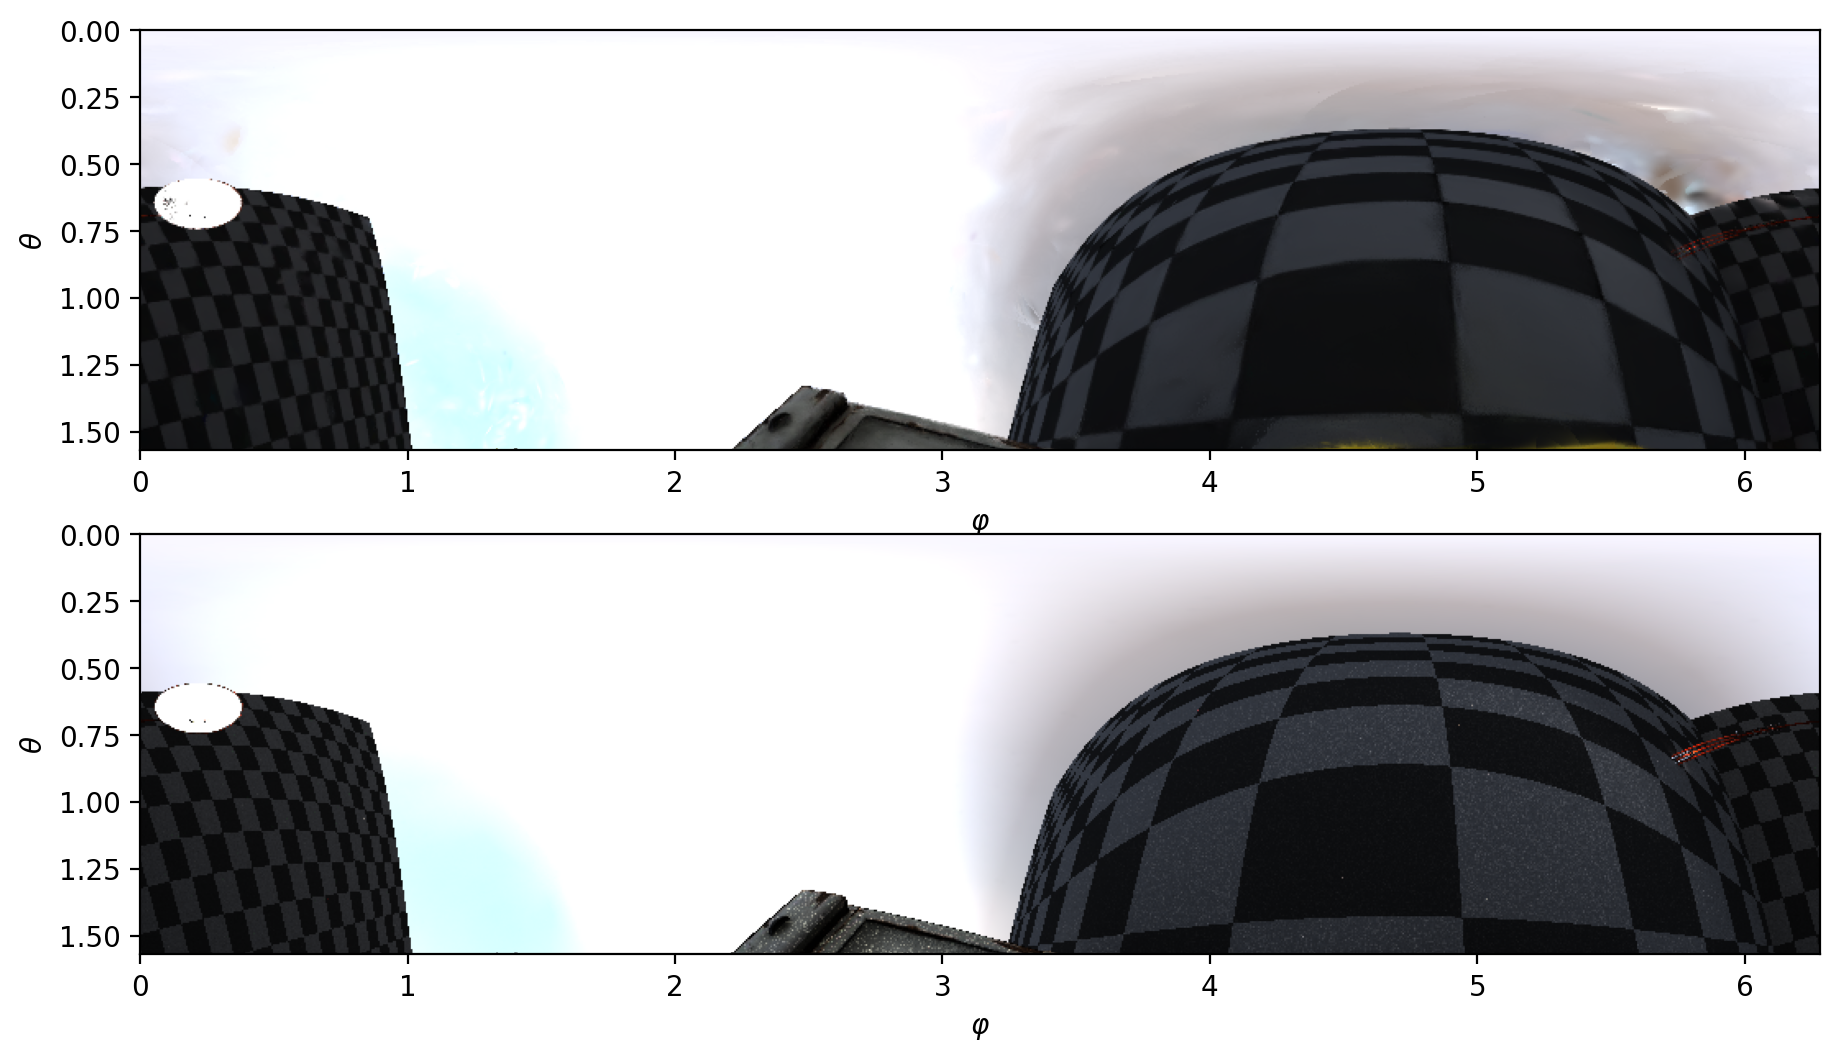

In [7]:
from scripts.radiosity.radiance_cache import render_hemisphere_rt, dir_to_sph, SamplingMethod
import matplotlib.pyplot as plt

sampler = mi.load_dict({'type': 'independent'})
seed = 200
si = scene_sampler.sample(1 << 0, sampler, rng_state=seed)[0]

N = 256
plt.figure(figsize=(13,6), dpi=200)
plt.subplot(211)
img_out, rays, I_out = radiance_cache._render_hemisphere_auto_offset(si, sampler, N)
plt.imshow(img_out, extent=[0, dr.two_pi, 0.5 * dr.pi, 0.0])
plt.xlabel(r"$\varphi$"); plt.ylabel(r"$\theta$")
mi.util.write_bitmap("fisheye_gs.exr", mi.Bitmap(img_out))

plt.subplot(212)
img_gt, rays, I_gt = render_hemisphere_rt(scene, si, sampler, N, spp = 256)
plt.imshow(img_gt, extent=[0, dr.two_pi, 0.5 * dr.pi, 0.0])
plt.xlabel(r"$\varphi$"); plt.ylabel(r"$\theta$")
mi.util.write_bitmap("fisheye_rt.exr", mi.Bitmap(img_gt))

print(f"Pointwise energy missing (rel.): {dr.sum(img_out - img_gt, axis=None) / dr.sum(img_gt, axis=None)}")
print(f"Pointwise energy abs diff. (rel.): {dr.sum(dr.abs(img_out - img_gt), axis=None) / dr.sum(img_gt, axis=None)}")
print(f"Hemispheric integral: {I_out} vs. {I_gt}")

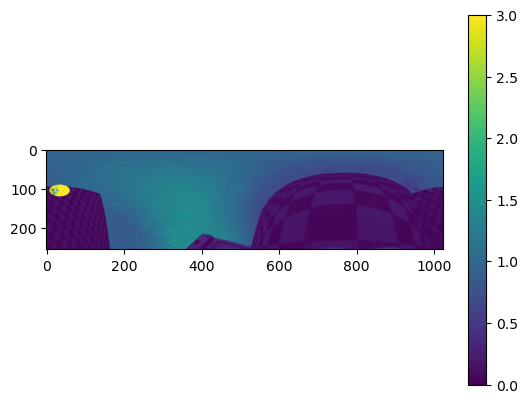

In [8]:
plt.figure(); plt.imshow(img_out.numpy()[:,:,0], vmin=0.0, vmax=3.0); plt.colorbar()

In [9]:
from restir.reservoir import ReservoirVector3f, MultiReservoirVector3f

def balance_heuristic(pdf_a: Float, pdf_b: Float) -> Float:
    return pdf_a * dr.rcp(pdf_a + pdf_b)

def eval_integrand(d: mi.Vector3f, si: mi.SurfaceInteraction3f, radiance_cache: RadianceCache, sampler: mi.Sampler, rng_state: int = 0):
    ray = radiance_cache._spawn_offset_ray(si, d)
    Le, rng_state = radiance_cache._pathtrace(ray, sampler, rng_state)
    return Le, rng_state

def eval_target_function(d: mi.Vector3f, si: mi.SurfaceInteraction3f, radiance_cache: RadianceCache, sampler: mi.Sampler, rng_state: int = 0):
    Le = eval_integrand(d, si, radiance_cache, sampler, rng_state)[0]
    p_hat = dr.norm(Le)
    return p_hat

def proposal_direction(si: mi.SurfaceInteraction3f, sample2: mi.Point2f):
    d_local = mi.warp.square_to_uniform_hemisphere(sample2)
    pdf     = mi.warp.square_to_uniform_hemisphere_pdf(d_local)
    d_world = si.to_world(d_local)
    return d_world, pdf

def eval_target_and_integrand(d: mi.Vector3f, si: mi.SurfaceInteraction3f, radiance_cache: RadianceCache, sampler: mi.Sampler, rng_state: int = 0):
    Le = eval_integrand(d, si, radiance_cache, sampler, rng_state)[0]
    p_hat = dr.norm(Le)
    return Le, p_hat

In [15]:
def run_naive(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        rng_state: int = 0) -> mi.Color3f:
    STREAM_LENGTH = M
    NUM_STREAMS = dr.width(si)

    sampler.seed(rng_state, NUM_STREAMS * STREAM_LENGTH); rng_state += 0x0010_0000
    si_wide = dr.gather(type(si), si, dr.repeat(dr.arange(UInt, NUM_STREAMS), STREAM_LENGTH))
    d, pdf = proposal_direction(si_wide, sampler.next_2d())
    integrand, rng_state = eval_integrand(d, si_wide, radiance_cache, sampler, rng_state)
    result = dr.mean(integrand * dr.rcp(pdf), axis=1)
    return result

def _run_singleslot(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        rng_state: int = 0) -> tuple[mi.Color3f, ReservoirVector3f]:
    '''
    Compute the hemispheric integral of f(x) using reservoir sampling with one slot.
    '''
    STREAM_LENGTH = M
    NUM_STREAMS = dr.width(si)

    rsv = ReservoirVector3f(NUM_STREAMS)
    si_wide = dr.gather(type(si), si, dr.repeat(dr.arange(UInt, NUM_STREAMS), STREAM_LENGTH))
    sampler.seed(rng_state, NUM_STREAMS * STREAM_LENGTH); rng_state += 0x0010_0000

    # Draw samples from the proposal distribution
    d_sample, pdf = proposal_direction(si_wide, sampler.next_2d())

    # Contrib. weight of drawn sample, `s.W`
    ds_W = dr.rcp(pdf)

    # Compute `p_hat`
    p_hat = eval_target_function(d_sample, si_wide, radiance_cache, sampler, rng_state)

    # Compute weight `w`
    mis_weight = 1.0 / M
    w = dr.select(pdf > 0.0, mis_weight * p_hat * ds_W, 0.0)

    # Add samples to reservoir
    rsv.add_proposals_vectorized(STREAM_LENGTH, d_sample, sampler, w)

    # Evaluate integrand and compute integral
    target_eval = lambda ds: eval_target_function(ds, si, radiance_cache, sampler, rng_state)
    d, contrib_weight = rsv.get_sample(target_eval)
    result = eval_integrand(d, si, radiance_cache, sampler, rng_state)[0] * contrib_weight
    return result, rsv

def _run_multislot(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        num_slots: int,
        rng_state: int = 0) -> tuple[mi.Color3f, MultiReservoirVector3f]:
    '''
    Compute the hemispheric integral of f(x) using reservoir sampling with `num_slots` 
    slots. All slots share the same input stream of proposals, of length `M`.
    '''
    STREAM_LENGTH = M
    NUM_STREAMS = dr.width(si)

    result = dr.zeros(mi.Color3f, NUM_STREAMS)
    rsv = MultiReservoirVector3f(NUM_STREAMS, num_slots)
    si_wide = dr.gather(type(si), si, dr.repeat(dr.arange(UInt, NUM_STREAMS), STREAM_LENGTH))
    sampler.seed(rng_state, NUM_STREAMS * STREAM_LENGTH); rng_state += 0x0010_0000

    # Draw samples from the proposal distribution
    d_sample, pdf = proposal_direction(si_wide, sampler.next_2d())

    # Contrib. weight of drawn sample, `s.W`
    ds_W = dr.rcp(pdf)

    # Compute `p_hat`
    p_hat = eval_target_function(d_sample, si_wide, radiance_cache, sampler, rng_state)

    # Compute weight `w`
    mis_weight = 1.0 / M
    w = dr.select(pdf > 0.0, mis_weight * p_hat * ds_W, 0.0)

    # Add samples to reservoir
    rsv.add_proposals_vectorized(STREAM_LENGTH, d_sample, sampler, w)

    # Evaluate integrand and compute integral
    for slot_idx in range(num_slots):
        d = rsv.sample[slot_idx]
        I, p_hat = eval_target_and_integrand(d, si, radiance_cache, sampler, rng_state)
        result += I * rsv.w_sum[slot_idx] * dr.rcp(p_hat)   # == I * contrib_weight
        rsv.p_hat[slot_idx] = p_hat

    # # Vectorized version (over `slots`)
    # ds = dr.zeros(mi.Vector3f, NUM_STREAMS * num_slots)
    # ws = dr.zeros(Float, NUM_STREAMS * num_slots)
    # for slot_idx in range(num_slots):
    #     scatter_idx = dr.arange(UInt, NUM_STREAMS) * num_slots + slot_idx
    #     dr.scatter(ds, rsv.sample[slot_idx], scatter_idx)
    #     dr.scatter(ws, rsv.w_sum[slot_idx],  scatter_idx)
    # si_wide = dr.gather(type(si), si, dr.repeat(dr.arange(UInt, NUM_STREAMS), num_slots))
    # I, p_hat = eval_target_and_integrand(ds, si_wide, radiance_cache, sampler, rng_state)
    # result = dr.block_sum(I * ws * dr.rcp(p_hat), block_size=num_slots)   # == I * contrib_weight

    result /= num_slots
    return result, rsv

def _run_singleslot_temporal(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        num_frames: int, 
        rng_state: int = 0) -> mi.Color3f:
    '''
    Compute the hemispheric integral of f(x) using reservoir sampling with one slot.
    '''
    STREAM_LENGTH = M
    NUM_STREAMS = dr.width(si)

    result, rsv_prev = _run_singleslot(radiance_cache, si, sampler, M, rng_state); rng_state += 0x0010_0000

    target_func = lambda ds: eval_target_function(ds, si, radiance_cache, sampler, rng_state)
    si_wide = dr.gather(type(si), si, dr.repeat(dr.arange(UInt, NUM_STREAMS), STREAM_LENGTH))

    sampler.seed(rng_state, NUM_STREAMS * STREAM_LENGTH)
    sampler_ = mi.load_dict({'type': 'independent'})
    sampler_.seed(rng_state + 0x0010_0000, NUM_STREAMS)
    for _ in range(num_frames - 1):
        rsv_curr = ReservoirVector3f(NUM_STREAMS)

        # Draw samples from the proposal distribution
        d_sample, pdf = proposal_direction(si_wide, sampler.next_2d())

        # Contrib. weight of drawn sample, `s.W`
        ds_W = dr.rcp(pdf)

        # Compute `p_hat`
        p_hat = eval_target_function(d_sample, si_wide, radiance_cache, sampler, rng_state)

        # Compute weight `w`
        mis_weight = 1.0 / M
        w = dr.select(pdf > 0.0, mis_weight * p_hat * ds_W, 0.0)

        # Add samples to reservoir
        rsv_curr.add_proposals_vectorized(STREAM_LENGTH, d_sample, sampler, w)

        # # Temporal reuse
        target_curr, target_prev = target_func, target_func

        # Add current iteration's reservoir
        rsv_curr.eval_target(target_curr)
        mis_curr = balance_heuristic(rsv_curr.p_hat, target_prev(rsv_curr.sample) * 20)
        rsv_curr.reinitialize(mis_curr)

        # Add previous iteration's reservoir
        tmp = rsv_prev.p_hat
        # print(tmp, target_prev(rsv_prev.sample))
        # print(tmp)
        prev_sample, prev_W = rsv_prev.get_sample(target_prev)
        # print(rsv_prev.p_hat)
        mis_prev = balance_heuristic(rsv_prev.p_hat * 20, target_curr(prev_sample))
        # rsv_curr.add_proposal(prev_sample, sampler_.next_1d(), mis_prev * rsv_prev.p_hat * prev_W, rsv_prev.c)
        rsv_curr.add_proposal(prev_sample, sampler_.next_1d(), mis_prev * rsv_prev.w_sum, rsv_prev.c)

        # # Evaluate integrand and compute integral
        # d = rsv_curr.sample
        # valid = rsv_curr.w_sum > 0.0
        # I, rsv_curr.p_hat = eval_target_and_integrand(d, si, radiance_cache, sampler, rng_state)
        # result = dr.select(valid, rsv_curr.w_sum * I / rsv_curr.p_hat, dr.zeros(mi.Color3f))
        d, contrib_weight = rsv_curr.get_sample(target_curr)
        result = eval_integrand(d, si, radiance_cache, sampler, rng_state)[0] * contrib_weight

        # Update reservoir buffer
        rsv_prev = rsv_curr
        dr.eval(rsv_prev)

    return result

def _run_multislot_temporal(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        num_slots: int,
        num_frames: int, 
        rng_state: int = 0) -> mi.Color3f:
    '''
    Compute the hemispheric integral of f(x) using reservoir sampling with one slot.
    '''
    STREAM_LENGTH = M
    NUM_STREAMS = dr.width(si)

    result, rsv_prev = _run_multislot(radiance_cache, si, sampler, M, num_slots, rng_state); rng_state += 0x0010_0000

    target_func = lambda ds: eval_target_function(ds, si, radiance_cache, sampler, rng_state)
    si_wide = dr.gather(type(si), si, dr.repeat(dr.arange(UInt, NUM_STREAMS), STREAM_LENGTH))

    sampler.seed(rng_state, NUM_STREAMS * STREAM_LENGTH)
    sampler_ = mi.load_dict({'type': 'independent'})
    sampler_.seed(rng_state + 0x0010_0000, NUM_STREAMS)
    for _ in range(num_frames - 1):
        result = dr.zeros(mi.Color3f, NUM_STREAMS)
        rsv_seed = MultiReservoirVector3f(NUM_STREAMS, num_slots)

        # Draw samples from the proposal distribution
        d_sample, pdf = proposal_direction(si_wide, sampler.next_2d())

        # Contrib. weight of drawn sample, `s.W`
        ds_W = dr.rcp(pdf)

        # Compute `p_hat`
        p_hat = eval_target_function(d_sample, si_wide, radiance_cache, sampler, rng_state)

        # Compute weight `w`
        mis_weight = 1.0 / M
        w = dr.select(pdf > 0.0, mis_weight * p_hat * ds_W, 0.0)

        # Add samples to reservoir
        rsv_seed.add_proposals_vectorized(STREAM_LENGTH, d_sample, sampler, w)

        # Temporal reuse
        rsv_reuse = MultiReservoirVector3f(NUM_STREAMS, num_slots)
        target_curr, target_prev = target_func, target_func

        for slot_idx in range(num_slots):
            # Add current iteration's reservoir
            curr_sample = rsv_seed.sample[slot_idx]
            p_hat_curr = target_curr(curr_sample)
            p_hat_prev = target_prev(curr_sample)
            mis_curr = balance_heuristic(p_hat_curr, p_hat_prev * 20)
            rsv_reuse.add_proposal_on_slot(slot_idx, curr_sample, sampler_.next_1d(), mis_curr * rsv_seed.w_sum[slot_idx])

            # Add previous iteration's reservoir
            prev_sample, prev_W = rsv_prev.get_sample(target_prev, slot_idx)
            p_hat_prev = rsv_prev.p_hat[slot_idx]
            p_hat_curr = target_curr(prev_sample)
            mis_prev = balance_heuristic(p_hat_prev * 20, p_hat_curr)
            rsv_reuse.add_proposal_on_slot(slot_idx, prev_sample, sampler_.next_1d(), mis_prev * rsv_prev.w_sum[slot_idx])

            # Evaluate integrand and compute integral
            d, contrib_weight = rsv_reuse.get_sample(target_func, slot_idx)
            result += eval_integrand(d, si, radiance_cache, sampler, rng_state)[0] * contrib_weight

        result /= num_slots
        # Update reservoir buffer
        rsv_prev = rsv_reuse
        dr.eval(result, rsv_prev)
    return result



def run_singleslot(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        rng_state: int = 0) -> mi.Color3f:
    return _run_singleslot(radiance_cache, si, sampler, M, rng_state)[0]

def run_multislot(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        rng_state: int = 0) -> mi.Color3f:
    num_slots = 4
    return _run_multislot(radiance_cache, si, sampler, M, num_slots, rng_state)[0]

def run_singleslot_temporal(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        rng_state: int = 0) -> mi.Color3f:
    num_frames = 16
    return _run_singleslot_temporal(radiance_cache, si, sampler, M, num_frames, rng_state)

def run_multislot_temporal(
        radiance_cache: RadianceCache,
        si: mi.SurfaceInteraction3f, 
        sampler: mi.Sampler, 
        M: int, 
        rng_state: int = 0) -> mi.Color3f:
    num_frames = 16
    num_slots = 4
    return _run_multislot_temporal(radiance_cache, si, sampler, M, num_slots, num_frames, rng_state)


import numpy as np
from time import time

with np.printoptions(precision=3, suppress=True):
    print(f"Reference: {I_out.numpy().ravel()}")

for method in [ run_singleslot_temporal, run_multislot_temporal]:
# for method in [run_naive, run_multislot_temporal]:
# for method in [run_naive, run_singleslot_temporal]:
    Ls = []
    t1 = time()
    for rng_state in range(10):
        STREAM_LENGTH = 1 << 6
        sampler = mi.load_dict({'type': 'independent'})
        L = method(radiance_cache, si, sampler, STREAM_LENGTH, rng_state)
        dr.eval(L)
        # print(L)
        Ls.append(L.numpy().T)
    t2 = time() - t1

    Ls_ = np.array(Ls).squeeze()
    mean = np.mean(Ls_, axis=0)
    std  = np.std (Ls_, axis=0)

    with np.printoptions(precision=3, suppress=True):
        print(f"{mean} +- {std}\t(Duration: {t2:.3f}s)")

Reference: [3.766 3.945 4.377]


[3.607 3.832 4.331] +- [1.115 1.112 1.256]	(Duration: 34.788s)
[3.047 3.212 3.613] +- [1.107 1.169 1.391]	(Duration: 133.827s)


In [11]:
[4.025 4.228 4.714] +- [1.358 1.37  1.447]	(Duration: 13.671s)


SyntaxError: invalid decimal literal (1699614987.py, line 1)

In [ ]:
# Multislot
[3.627 3.833 4.291] +- [0.273 0.266 0.324]


# Temporal
[3.444 3.622 3.993] +- [0.376 0.28  0.252]

# [3.635 3.828 4.283] +- [0.275 0.274 0.283]
# [3.662 3.852 4.247] +- [0.396 0.291 0.271]
# [3.627 3.833 4.291] +- [0.273 0.266 0.324]
# [4.121 4.203 4.399] +- [5.225 5.184 5.113]

In [ ]:
# import numpy as np

# for LOG_STREAM_LENGTH in [5, 8, 10, 12, 14, 16]:
#     Ls = []
#     for rng_state in range(10):
#         STREAM_LENGTH = 1 << LOG_STREAM_LENGTH
#         sampler = mi.load_dict({'type': 'independent'})
#         L = run_naive(radiance_cache, si, sampler, STREAM_LENGTH, rng_state)[0]
#         dr.eval(L)
#         Ls.append(L.numpy().T)

#     Ls_ = np.array(Ls).squeeze()
#     mean = np.mean(Ls_, axis=0)
#     std  = np.std (Ls_, axis=0)
#     print(f"mean=[{mean[0]:.3f}, {mean[1]:.3f}, {mean[2]:.3f}]")
#     print(f" std=[{ std[0]:.3f}, { std[1]:.3f}, { std[2]:.3f}]")


# for NUM_SLOTS in [1,2,4,8,16,32]:
#     Ls = []
#     for rng_state in range(10):
#         STREAM_LENGTH = 1 << 5
#         sampler = mi.load_dict({'type': 'independent'})
#         L, rng_state = run(radiance_cache, si, sampler, STREAM_LENGTH, NUM_SLOTS, rng_state)
#         dr.eval(L)
#         Ls.append(L.numpy().T)

#     Ls = np.array(Ls).squeeze()

#     mean = np.mean(Ls, axis=0)
#     std  = np.std (Ls, axis=0)
#     print(f"mean=[{mean[0]:.3f}, {mean[1]:.3f}, {mean[2]:.3f}]")
#     print(f" std=[{ std[0]:.3f}, { std[1]:.3f}, { std[2]:.3f}]")

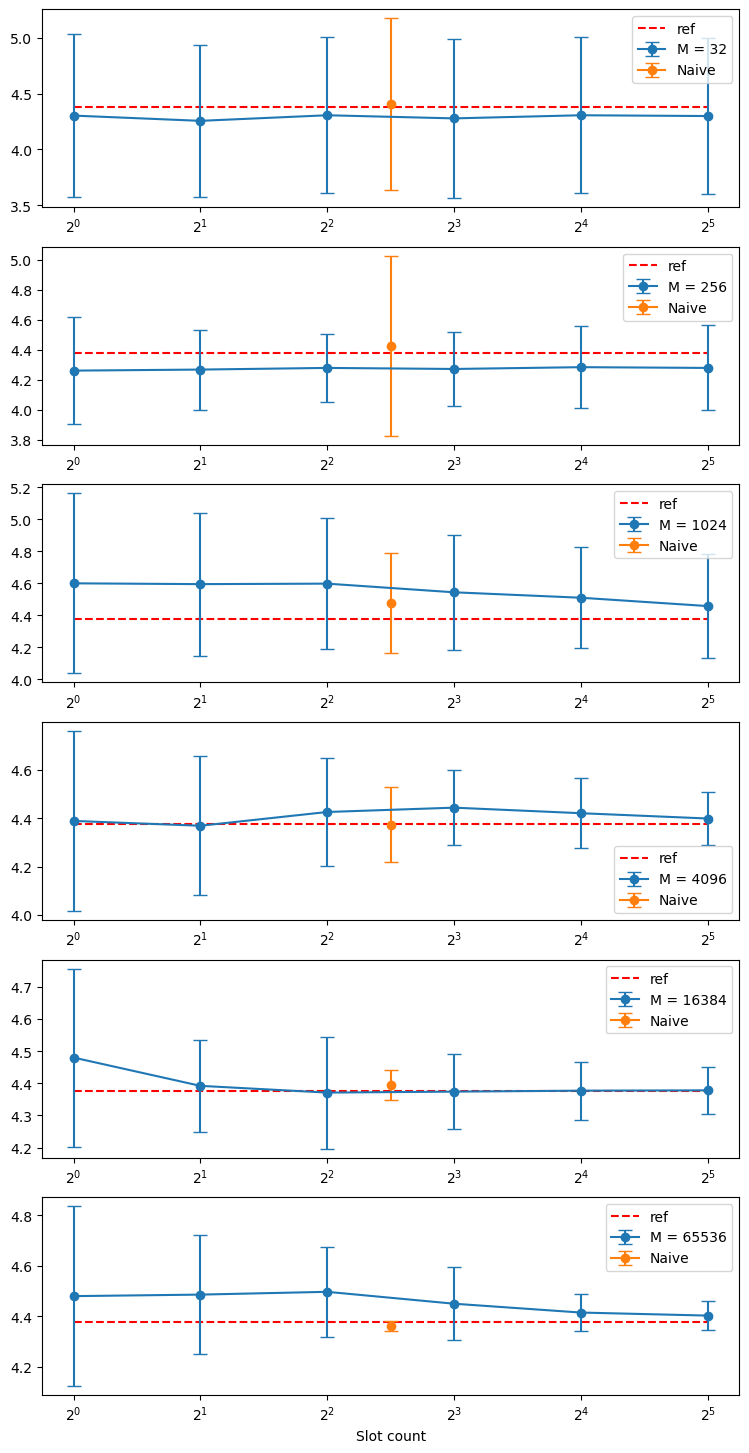

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

true_mean = np.array([3.76566, 3.94546, 4.3773])

curves = [
    {
        'label': f"M = {1 << 5}",
        'data': np.array([
            [3.630, 3.839, 4.304],
            [0.652, 0.643, 0.729],
            [3.677, 3.848, 4.257],
            [0.660, 0.649, 0.684],
            [3.628, 3.834, 4.307],
            [0.626, 0.645, 0.701],
            [3.657, 3.837, 4.279],
            [0.607, 0.641, 0.715],
            [3.628, 3.828, 4.307],
            [0.626, 0.644, 0.701],
            [3.637, 3.830, 4.300],
            [0.622, 0.642, 0.702],
        ]),
        'data_naive': np.array([
            [3.708, 3.920, 4.406],
            [0.608, 0.660, 0.772],
        ])
     },
    {
        'label': f"M = {1 << 8}",
        'data': np.array([
            [3.655, 3.843, 4.261],
            [0.325, 0.266, 0.357],
            [3.647, 3.840, 4.268],
            [0.363, 0.293, 0.267],
            [3.641, 3.833, 4.279],
            [0.355, 0.300, 0.224],
            [3.646, 3.836, 4.272],
            [0.322, 0.290, 0.245],
            [3.635, 3.831, 4.284],
            [0.300, 0.281, 0.273],
            [3.639, 3.830, 4.279],
            [0.287, 0.276, 0.283],
        ]),
        'data_naive': np.array([
            [3.808, 3.990, 4.427],
            [0.607, 0.604, 0.600],
        ])
     },
    {
        'label': f"M = {1 << 10}",
        'data': np.array([
            [3.688, 3.978, 4.600],
            [0.264, 0.241, 0.562],
            [3.695, 3.978, 4.595],
            [0.281, 0.272, 0.447],
            [3.690, 3.976, 4.598],
            [0.234, 0.268, 0.409],
            [3.741, 3.991, 4.544],
            [0.254, 0.275, 0.360],
            [3.775, 4.001, 4.510],
            [0.277, 0.284, 0.314],
            [3.826, 4.013, 4.458],
            [0.266, 0.282, 0.325],
        ]),
        'data_naive': np.array([
            [3.871, 4.048, 4.478],
            [0.307, 0.308, 0.313],
        ])
     },
    {
        'label': f"M = {1 << 12}",
        'data': np.array([
            [3.734, 3.939, 4.389],
            [0.254, 0.066, 0.373],
            [3.750, 3.947, 4.369],
            [0.168, 0.058, 0.288],
            [3.701, 3.930, 4.426],
            [0.100, 0.060, 0.225],
            [3.685, 3.921, 4.444],
            [0.080, 0.074, 0.156],
            [3.709, 3.928, 4.421],
            [0.073, 0.075, 0.144],
            [3.729, 3.936, 4.399],
            [0.089, 0.084, 0.108],
        ]),
        'data_naive': np.array([
            [3.762, 3.942, 4.374],
            [0.144, 0.147, 0.154],
        ])
     },
    {
        'label': f"M = {1 << 14}",
        'data': np.array([
            [3.652, 3.913, 4.480],
            [0.282, 0.084, 0.277],
            [3.738, 3.937, 4.392],
            [0.164, 0.067, 0.144],
            [3.757, 3.941, 4.371],
            [0.140, 0.050, 0.174],
            [3.757, 3.935, 4.374],
            [0.067, 0.050, 0.117],
            [3.751, 3.938, 4.377],
            [0.067, 0.058, 0.090],
            [3.749, 3.938, 4.378],
            [0.057, 0.058, 0.074],
        ]),
        'data_naive': np.array([
            [3.781, 3.961, 4.394],
            [0.045, 0.045, 0.046],
        ])
     },
    {
        'label': f"M = {1 << 16}",
        'data': np.array([
            [3.646, 3.929, 4.480],
            [0.354, 0.099, 0.356],
            [3.647, 3.921, 4.486],
            [0.236, 0.067, 0.234],
            [3.643, 3.914, 4.497],
            [0.190, 0.060, 0.179],
            [3.690, 3.924, 4.450],
            [0.146, 0.048, 0.144],
            [3.729, 3.935, 4.415],
            [0.077, 0.031, 0.073],
            [3.741, 3.938, 4.403],
            [0.038, 0.017, 0.056],
        ]),
        'data_naive': np.array([
            [3.753, 3.932, 4.363],
            [0.020, 0.020, 0.020],
        ])
     },
     ]


Ms = np.array([1,2,4,8,16,32])
CH_R, CH_G, CH_B = 0, 1, 2
CH = CH_B

plt.figure(figsize=(9,18)); 
num_curves = len(curves)
for i, curve in enumerate(curves):
    plt.subplot(num_curves, 1, i+1)
    data = curve['data']
    label = curve['label']
    data_naive = curve['data_naive']

    plt.plot(Ms, np.full(len(Ms), true_mean[CH]), 'r--', label="ref")

    means, stds = data[0::2], data[1::2]
    plt.errorbar(Ms, means[:,CH], yerr=stds[:,CH], capsize=5.0, fmt='o-', label=label)

    means_naive = data_naive[0]
    stds_naive  = data_naive[1]
    plt.errorbar([2 ** 2.5], means_naive[CH], yerr=stds_naive[CH], capsize=5.0, fmt='o-', label="Naive")
    plt.legend()
    plt.gca().set_xscale('log', base=2)

    if i == num_curves - 1:
        plt.xlabel("Slot count")
    # plt.ylim(2.5, 5)
    # plt.ylim(3.0, 5.5)